# Plotting Source Sink Cross Validation Experiment

Acknowledgements: See https://github.com/sipv/MultipanelFigures/blob/main/MultipanelFigures.ipynb for a great explanation on laying out figures in matplotlib

In [28]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [1]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
from pprint import pprint
import re

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

from sklearn.metrics import auc

import pingouin as pg
from mlxtend.evaluate import mcnemar_table, mcnemar
import dabest

import sys

sys.path.append("../../")
from episcalp.utils.standard_1020_montage import get_standard_1020_montage

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set Plotting Options

In [2]:
# Set font sizes
SMALL_SIZE = 8 * 2
MEDIUM_SIZE = 10 * 2
BIGGER_SIZE = 12 * 2

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc("font", **{"family": "sans-serif", "sans-serif": ["Arial"]})

In [3]:
def load_participant_df(root, subject):
    """Load participants.tsv file as a dataframe for a specific subject.

    Note: subject ID needs to be in format ``sub-<subject>``.
    """
    df = pd.read_csv(os.path.join(root, "participants.tsv", sep="\t"))
    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"
    subj_row = df[df["participant_id"] == subject]
    return subj_row

# Load Data

In [4]:
user = "patrick"
if user == "patrick":
    jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
    jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")
elif user == "adam":
    jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
    jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [5]:
if user == "adam":
    root = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/")
elif user == "patrick":
    root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
deriv_root = root / "derivatives"
deriv_path = deriv_root

In [6]:
figure_dir = deriv_root / "figures"

## Load Experimental Data from JSON - output of sklearn's "cross_validate" function

In [229]:
# here name the experiment something that is uniquely identifiable
# THIS STR WILL BE USED TO PREFIX/SUFFIX ALL FIGURES DOWNSTREAM
exp_name = "fragility_benchmark"
exp_name = "spikes_benchmark"
exp_name = "tfrdelta_benchmark"
exp_name = "betaquantiles_jhhjeff_spikes"

In [154]:
n_splits = 20

# clf_name = "rf"
clf_name = "lr"
max_features = 5

In [9]:
pprint(list(deriv_root.glob("*.json")))

[WindowsPath('D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids/derivatives/cv10_logreg_mtry5_exp_ssdist_meandiff.json'),
 WindowsPath('D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids/derivatives/cv10_rf_mtry28_exp_fragility_alleeg.json'),
 WindowsPath('D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids/derivatives/cv10_rf_mtry28_exp_fragility_alphaO1O2_alleeg.json'),
 WindowsPath('D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids/derivatives/cv10_rf_mtry28_exp_fragility_alphaO1O2_multiclass.json'),
 WindowsPath('D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids/derivatives/cv10_rf_mtry28_exp_fragility_benchmark_alleeg.json'),
 WindowsPath('D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids/derivatives/cv10_rf_mtry28_exp_fragility_multiclass.json'),
 WindowsPath('D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids/derivatives/cv10_rf_mtry32_exp_fragility_benchmark_alleeg.json'),
 Wind

In [230]:
# specify the filenmae
fname = (
    deriv_root
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_{exp_name}.json"  # _without_abnormaleeg.json"
)
print(fname)

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\cv20_lr_mtry5_betaquantiles_jhhjeff_spikes.json


In [231]:
with open(fname.with_suffix(".json"), "r") as fp:
    scores = json.load(fp)

In [12]:
ch_names = get_standard_1020_montage()
print(len(ch_names))

ch_names = [
    "Fp1",
    "Fp2",
    "F3",
    "F4",
    #"C3",
    #"C4",
    "P3",
    "P4",
    "O1",
    "O2",
    "F7",
    "F8",
    "T3",
    "T4",
    "T5",
    "T6",
]

23


# Load Metadata DataFrame

In [66]:
meta_df = pd.DataFrame()
for root in [jhroot, jeffroot]:
    df = pd.read_csv(os.path.join(root, "participants.tsv"), sep="\t")
    meta_df = pd.concat((meta_df, df), axis=0)

# meta_df = pd.concat(df_list, axis=0)

display(meta_df.head())

,participant_id,age,sex,hand,site,exp_condition,outcome,num_aeds,final_diagnosis,epilepsy_type,epilepsy_hemisphere,epilepsy_lobe,orig_sub_id
0,sub-jhh001,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
1,sub-jhh002,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
2,sub-jhh003,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
3,sub-jhh004,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN
4,sub-jhh005,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN


# Make Plots of the Derived Dataset

In [232]:
# either train or test set
which_set = "test"

# construct mean/std ROC curves
tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]
    thresh = scores[f"{which_set}_thresholds"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

## Print out Summary Statistics

In [15]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_cohen_kappa_score', 'train_cohen_kappa_score', 'test_roc_auc', 'train_roc_auc', 'test_f1', 'train_f1', 'test_recall', 'train_recall', 'test_precision', 'train_precision', 'test_jaccard', 'train_jaccard', 'test_average_precision', 'train_average_precision', 'test_neg_brier_score', 'train_neg_brier_score', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity', 'test_y', 'test_y_encodings', 'y_classes', 'abnormal_fpaths'])


In [20]:
len(scores['abnormal_fpaths'])

16

In [54]:
thresh = scores['test_thresholds']
print(thresh)

[[1.9969999999999999, 0.997, 0.994, 0.993, 0.975, 0.974, 0.972, 0.967, 0.96, 0.899, 0.887, 0.7, 0.618, 0.392, 0.247, 0.102, 0.098, 0.012], [1.999, 0.999, 0.998, 0.997, 0.71, 0.705, 0.646, 0.64, 0.614, 0.577, 0.483, 0.351, 0.074, 0.02], [1.9889999999999999, 0.989, 0.865, 0.844, 0.711, 0.587, 0.456, 0.431, 0.399, 0.376, 0.324, 0.294, 0.266, 0.22, 0.104], [1.9969999999999999, 0.997, 0.991, 0.98, 0.646, 0.64, 0.63, 0.597, 0.519, 0.517, 0.49, 0.404, 0.368, 0.254], [1.998, 0.998, 0.99, 0.987, 0.973, 0.971, 0.951, 0.9, 0.684, 0.515, 0.443, 0.171, 0.15, 0.137, 0.049, 0.022], [1.991, 0.991, 0.967, 0.963, 0.932, 0.923, 0.899, 0.88, 0.878, 0.859, 0.734, 0.73, 0.412, 0.281, 0.185, 0.108, 0.077], [1.999, 0.999, 0.997, 0.994, 0.993, 0.991, 0.95, 0.928, 0.743, 0.673, 0.486, 0.393, 0.368, 0.213], [1.995, 0.995, 0.985, 0.983, 0.981, 0.955, 0.953, 0.87, 0.862, 0.754, 0.749, 0.641, 0.632, 0.621, 0.515, 0.447, 0.328, 0.215, 0.162, 0.158, 0.155, 0.033], [1.9969999999999999, 0.997, 0.994, 0.959, 0.944, 0.88

In [77]:
aucs = scores["test_roc_auc"]
extra_str = ""

In [78]:
print(np.mean(aucs), np.std(aucs))

0.5177083333333333 0.09152309027313865


In [233]:
metric = f"test_balanced_accuracy"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_balanced_accuracy 0.5631628787878789 +/- 0.046938662003752074


In [80]:
metric = f"test_precision{extra_str}"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_precision 0.6989434687999762 +/- 0.03210841393569382


In [81]:
metric = f"test_recall{extra_str}"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_recall 0.84375 +/- 0.08108958523345236


In [82]:
metric = f"test_f1{extra_str}"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_f1 0.7634829686981432 +/- 0.04821750952767362


In [234]:
metric = "test_specificity"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_specificity 0.1909090909090909 +/- 0.09491187735373227


In [235]:
# create a dataframe from the statistics
temp_scores = scores.copy()
test_y_encodings = scores['test_y_encodings']
y_classes = scores['y_classes']
abnormal_fpaths = scores['abnormal_fpaths']
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
                "test_y_encodings",
                "y_classes",
                "abnormal_fpaths"
            ]
        ]
    ):
        temp_scores.pop(key)
for key, val in temp_scores.items():
    print(f"{key}: {len(val)}")
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

fit_time: 20
score_time: 20
test_balanced_accuracy: 20
test_cohen_kappa_score: 20
test_roc_auc: 20
test_f1: 20
test_recall: 20
test_precision: 20
test_jaccard: 20
test_average_precision: 20
test_neg_brier_score: 20
test_specificity: 20
test_y: 20


,fit_time,score_time,test_balanced_accuracy,test_cohen_kappa_score,test_roc_auc,test_f1,test_recall,test_precision,test_jaccard,test_average_precision,test_neg_brier_score,test_specificity,test_y
0,0.013003,0.006001,0.615530,0.279176,0.681818,0.836364,0.958333,0.741935,0.718750,0.739593,0.257143,0.272727,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, ..."
1,0.012002,0.006001,0.615530,0.279176,0.780303,0.836364,0.958333,0.741935,0.718750,0.739593,0.257143,0.272727,"[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, ..."
2,0.011002,0.007001,0.528409,0.066667,0.715909,0.777778,0.875000,0.700000,0.636364,0.698214,0.342857,0.181818,"[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, ..."
3,0.011002,0.006001,0.524621,0.063260,0.787879,0.807018,0.958333,0.696970,0.676471,0.696501,0.314286,0.090909,"[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ..."
4,0.012002,0.006001,0.615530,0.279176,0.693182,0.836364,0.958333,0.741935,0.718750,0.739593,0.257143,0.272727,"[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, ..."


In [25]:
# score_df.describe().to_csv(figure_dir / f"{exp_name}_{exp_name}_metrics_meansstd.csv")

## Making ROC Curve With Confidence Interval

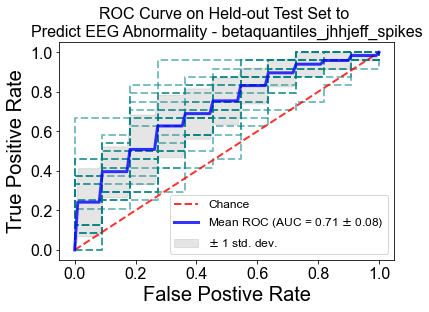

In [236]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set to \nPredict EEG Abnormality - {exp_name}",
    xlabel="False Postive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right", fontsize=12)

# And save it to PDF
fig.savefig(figure_dir / f"roc_curve_{exp_name}.pdf", bbox_inches="tight")

# Boxplot of Metrics

In [27]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_roc_auc', 'train_roc_auc', 'test_accuracy', 'train_accuracy', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_average_precision', 'train_average_precision', 'test_precision', 'train_precision', 'test_neg_brier_score', 'train_neg_brier_score', 'test_recall', 'train_recall', 'test_f1', 'train_f1', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity', 'test_y', 'test_y_encodings'])


In [100]:
test_subjs_ = scores['test_subjects']
test_subjs = [item for sublist in test_subjs_ for item in sublist]
len(test_subjs)

700

In [237]:
metrics = [
    "test_f1",
    "test_recall",
    "test_precision",
    "test_balanced_accuracy",
    #     "test_neg_brier_score",
]

df = pd.DataFrame()
for metric in metrics:
    metric_scores = scores[metric]
    df[metric] = metric_scores

df = pd.melt(df, value_name="value", var_name="metric")

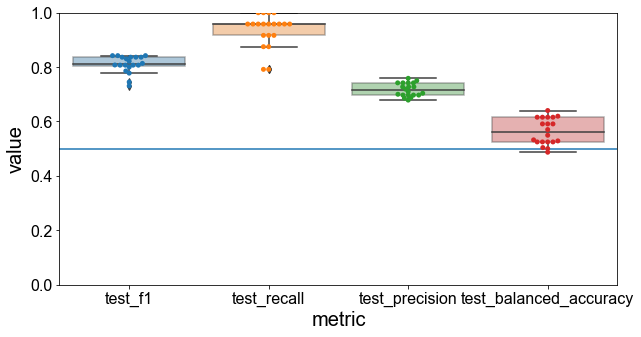

In [238]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(
    x="metric",
    y="value",
    #     color="gray",
    data=df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="metric",
    y="value",
    #     hue="exp_condition",
    #               color="black",
    data=df,
    ax=ax,
)
ax.set(ylim=[0, 1])
ax.axhline(0.5, label="chance")

## Plotting Predicted Probability of Success Scores

In [239]:
# TODO: modify to fit the participants framework
y_probas = []
subj_list = []
folds = []

# experimental condition
exp_conditions = []
y_outcomes = []
centers = []
num_aeds = []
final_diagnosis = []
epilepsy_types = []
epilepsy_hemisphere = []
epilepsy_lobe = []

# create dataframe over the entire cross validation
for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]
    cv_subjects = scores[f"{which_set}_subjects"][idx]
    for subject in cv_subjects:
        # extract column data for each subject
        outcome = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "exp_condition"
        ].values[0]
        aeds = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "num_aeds"
        ].values[0]
        diagnosis = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "final_diagnosis"
        ].values[0]
        epi_type = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "epilepsy_type"
        ].values[0]
        epi_hemisphere = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "epilepsy_hemisphere"
        ].values[0]
        epi_lobe = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "epilepsy_lobe"
        ].values[0]
        
        # this should match the original
        if outcome.startswith("epilepsy"):
            y_outcome = "epilepsy"
        else:
            y_outcome = outcome
        y_outcomes.append(y_outcome)
        exp_conditions.append(outcome)
        num_aeds.append(aeds)
        
        if subject.startswith("jhh"):
            center = "JHH"
        elif subject.startswith("jeff"):
            center = "Jefferson"
        elif subject.startswith("upmc"):
            center = "UPMC"
        centers.append(center)

    y_probas.extend(y_pred_proba)
    subj_list.extend(cv_subjects)
    folds.extend([idx] * len(cv_subjects))

In [240]:
for ab_fpath in abnormal_fpaths:
    y_probas.append(1.0)
    sub_str = ab_fpath.split("_")[0].split("-")[1]
    sub_id = int(re.search(r'\d+', sub_str).group())
    subj_list.append(sub_id)
    center_id = sub_str.replace(str(sub_id), "")
    centers.append(center_id.upper())
    folds.append(-1)
    if sub_id < 100:
        exp_conditions.append("non-epilepsy-normal-eeg")
        y_outcomes.append("non-epilepsy-normal-eeg")
    elif sub_id > 200:
        exp_conditions.append("epilepsy-abnormal-eeg")
        y_outcomes.append("epilepsy")
    else:
        exp_conditions.append("epilepsy-normal-eeg")
        y_outcomes.append("epilepsy")

In [241]:
proba_df = pd.DataFrame(
    (y_probas, subj_list, exp_conditions, y_outcomes, centers, folds)
).T
proba_df.columns = ["y_proba", "subject", "exp_condition", "outcome", "center", "fold"]

display(proba_df.tail())

,y_proba,subject,exp_condition,outcome,center,fold
711,1.0,213,epilepsy-abnormal-eeg,epilepsy,JHH,-1
712,1.0,216,epilepsy-abnormal-eeg,epilepsy,JHH,-1
713,1.0,213,epilepsy-abnormal-eeg,epilepsy,JHH,-1
714,1.0,216,epilepsy-abnormal-eeg,epilepsy,JHH,-1
715,1.0,206,epilepsy-abnormal-eeg,epilepsy,JEFF,-1


In [242]:
y_trues = []
for outcome in y_outcomes:
    if outcome == "epilepsy":
        y_trues.append(1)
    else:
        y_trues.append(0)


[Text(0, 0.5, 'Predicted Probability of Epilepsy'),
 Text(0.5, 0, 'Experimental Condition')]

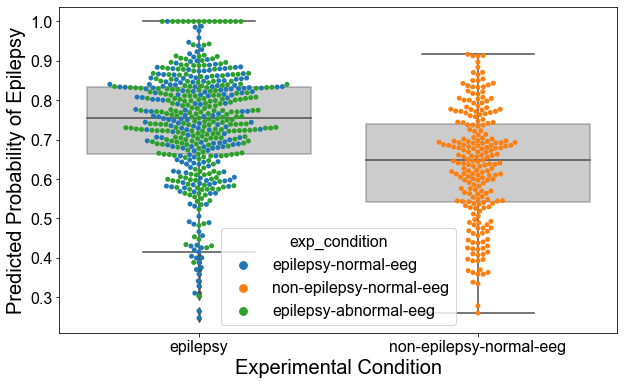

In [243]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="outcome",
    y="y_proba",
    color="gray",
    data=proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="outcome",
    y="y_proba",
    hue="exp_condition",
    #               color="black",
    data=proba_df,
    ax=ax,
)

ax.set(
    ylabel="Predicted Probability of Epilepsy",
    xlabel="Experimental Condition",
)
# fig.savefig(figure_dir / f"{exp_name}_y_pred_proba_surgical_outcomes.pdf", bbox_inches="tight")

## Boundary Split Figure

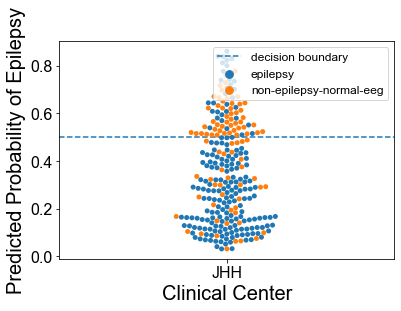

In [112]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axhline([0.5], ls="--", label="decision boundary")
# sns.boxplot(
#     x="center",
#     y="y_proba",
#     data=proba_df,
#     color="gray",
#     ax=ax,
#     boxprops=dict(alpha=0.4),
# )
sns.swarmplot(x="center", y="y_proba", hue="outcome", data=proba_df, ax=ax)
ax.set(
    ylabel="Predicted Probability of Epilepsy",
    xlabel="Clinical Center",
)
ax.legend(fontsize=12)
# fig.savefig(figure_dir / f"{exp_name}_boundary_split_center.pdf", bbox_inches="tight")

## Plotting Calibration Curve

In [53]:
mean_brier = np.mean(scores["test_neg_brier_score"])
std_brier = np.std(scores["test_neg_brier_score"])

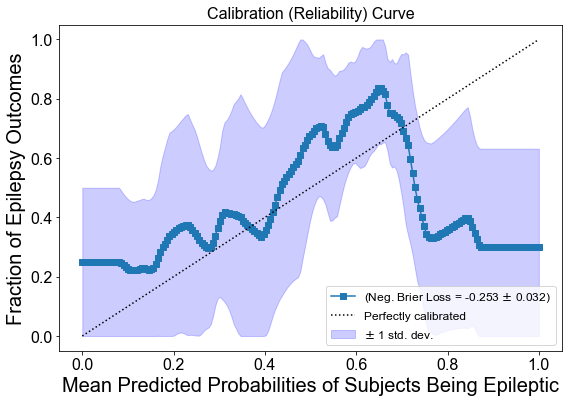

In [32]:
frac_pred_vals = []
mean_pred_values = np.linspace(0, 1.0, 200)

fig, ax = plt.subplots(figsize=(9, 6))
color = "blue"
for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]

    mean_predicted_value = scores[f"{which_set}_mean_pred_value"][idx]
    fraction_of_positives = scores[f"{which_set}_fraction_pos"][idx]

    # create a linear interpolation of the calibration
    interp_frac_positives = np.interp(
        mean_pred_values, mean_predicted_value, fraction_of_positives
    )

    # store curves
    frac_pred_vals.append(interp_frac_positives)
#     ax.plot(mean_pred_values, interp_frac_positives, "s-", alpha=0.5)

# get the mean calibration curve
mean_frac_pred_values = np.mean(frac_pred_vals, axis=0)
ax.plot(
    mean_pred_values,
    mean_frac_pred_values,
    "s-",
    label=rf"(Neg. Brier Loss = {np.round(mean_brier,3)} $\pm$ {np.round(std_brier, 3)})",
)

# get upper and lower bound for tpr
std_fpv = np.std(frac_pred_vals, axis=0)
tprs_upper = np.minimum(mean_frac_pred_values + std_fpv, 1)
tprs_lower = np.maximum(mean_frac_pred_values - std_fpv, 0)
ax.fill_between(
    mean_pred_values,
    tprs_lower,
    tprs_upper,
    color=color,
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


ax.set(
    ylabel="Fraction of Epilepsy Outcomes",
    ylim=[-0.05, 1.05],
    xlabel="Mean Predicted Probabilities of Subjects Being Epileptic",
    title="Calibration (Reliability) Curve",
)

ax.legend(loc="lower right", fontsize=12)

# fig.savefig(figure_dir / f"{exp_name}_calibration_curve.pdf", bbox_inches="tight")

# Look at Feature Importances

In [69]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_roc_auc', 'train_roc_auc', 'test_accuracy', 'train_accuracy', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_average_precision', 'train_average_precision', 'test_precision', 'train_precision', 'test_neg_brier_score', 'train_neg_brier_score', 'test_recall', 'train_recall', 'test_f1', 'train_f1', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity'])


In [82]:
importances = scores["test_importances"]
print(len(importances))
print([np.array(x).shape for x in importances])

10
[(32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5)]


done


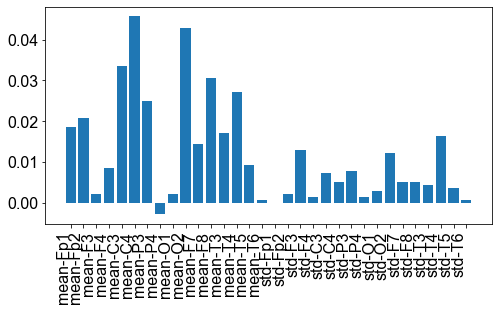

In [110]:
mean_imp = np.array([np.mean(x, axis=1) for x in importances]).mean(axis=0)
std_imp = np.array([np.std(x, axis=1) for x in importances]).mean(axis=0)

# plt.figure()
# sns.heatmap(mean_imp, xticklabels=chr)

# plt.figure()
# sns.heatmap(std_imp)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(np.arange(len(mean_imp)), mean_imp)
ax.set(
    xticks=np.arange(len(mean_imp)),
)
ax.set_xticklabels(
    [f"mean-{ch}" for ch in ch_names] + [f"std-{ch}" for ch in ch_names],
    rotation=90,
    ha="right",
)
print("done")

# Analyze Problematic Folds

In [56]:
metric = "test_roc_auc"

metric_list = []
subject_list = []

for idx in range(n_splits):
    metric_list.append(scores[metric][idx])
    subject_list.append(scores["test_subjects"][idx])

In [57]:
sorted_idx = np.argsort(metric_list)
print(np.array(metric_list)[sorted_idx])
print(sorted_idx)

[0.42222222 0.53333333 0.53333333 0.55555556 0.55555556 0.61111111
 0.65555556 0.68888889 0.71111111 0.71111111]
[5 8 4 1 3 9 2 7 0 6]


In [73]:
def _get_subject_intersections(indices, scores, key="test_subjects"):
    subs = []
    for idx in indices:
        subs.extend(scores[key][idx])

    # get subjects and occurrences in each fold
    subjects, counts = np.unique(subs, return_counts=True)

    sorted_idx = np.argsort(counts)[::-1]
    return subjects[sorted_idx], counts[sorted_idx]


subjects, counts = _get_subject_intersections(
    sorted_idx[:3], scores=scores, key="test_subjects"
)
# subjects, counts = _get_subject_intersections(
#     sorted_idx[:3], scores=scores, key="train_subjects"
# )

## Print out incorrectly annotated set of subjects

In [76]:
print("Consistently incorrectly annotated set of subjects")

for subject in subjects:
    subj_pred_probas = []
    for idx in range(n_splits):
        # get the index of the subject in test subjects for each fold
        if not subject in scores["test_subjects"][idx]:
            continue
        subj_idx = scores["test_subjects"][idx].index(subject)
        y_pred_proba = scores["test_y_pred_proba"][idx][subj_idx]

        subj_pred_probas.append(y_pred_proba)

    outcome = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
        "exp_condition"
    ].values[0]

    if outcome.startswith("epilepsy"):
        outcome = 1
    elif outcome.startswith("non-epilepsy"):
        outcome = 0

    if outcome == 1 and np.mean(subj_pred_probas) > 0.5:
        continue
    elif outcome == 0 and np.mean(subj_pred_probas) < 0.5:
        continue

    print(subject)
#     print(outcome, subj_pred_probas)

Consistently incorrectly annotated set of subjects
jhh027
0 [0.6722499999999999, 0.6873666666666666, 0.6216666666666666]
jhh125
1 [0.24125000000000002, 0.29491666666666666, 0.11853333333333335, 0.15266666666666664, 0.15683333333333335]
jhh113
1 [0.3903833333333333, 0.4400833333333333, 0.5288333333333333]
jhh008
0 [0.6361666666666667, 0.66075, 0.6799999999999999, 0.7066666666666668]
jhh124
1 [0.1826666666666667, 0.23241666666666666, 0.14833333333333334, 0.28824999999999995, 0.2718333333333333, 0.13266666666666665]
jhh028
0 [0.5271999999999999, 0.5120666666666666, 0.7125999999999999, 0.33175000000000004, 0.6092000000000001]
jhh116
1 [0.43693333333333334, 0.4655833333333333]
jhh019
0 [0.6230833333333332]
jhh003
0 [0.7310833333333333, 0.6947333333333334, 0.6423666666666665, 0.6657000000000002]
jhh010
0 [0.7201666666666666, 0.7330833333333334, 0.6645000000000001, 0.46244999999999997]
jhh012
0 [0.5806666666666667, 0.6784166666666667, 0.43625]
jhh015
0 [0.5006666666666667, 0.5336166666666666,

In [18]:
for idx in range(n_splits):
    test_subs = scores["test_subjects"][idx]

    for subject in test_subs:
        outcome = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "exp_condition"
        ].values[0]

# McNemars Test To Compare Two Different Classification Scenarios

In [55]:
from numpy.testing import assert_array_equal

In [56]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

In [57]:
y_target = []
y_modelhfo = []
y_modelss = []

y_subjs = []
for idx in range(n_splits):
    y = ss_scores["test_subjects"][idx]
    hfo_y = hfo_scores["test_subjects"][idx]

    assert_array_equal(y, hfo_y)
    y_subjs.extend(y)

    y_predhfo = hfo_scores["test_y_pred_proba"][idx]
    y_predss = ss_scores["test_y_pred_proba"][idx]
    y_modelhfo.extend(y_predhfo)
    y_modelss.extend(y_predss)

In [58]:
for subject in y_subjs:
    outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
    y_target.append(outcome)

y_target = enc.fit_transform(np.array(y_target)[:, np.newaxis]).squeeze()
y_modelss = np.array(y_modelss).round()
y_modelhfo = np.array(y_modelhfo).round()

In [59]:
tb = mcnemar_table(y_target=y_target, y_model1=y_modelss, y_model2=y_modelhfo)
print(tb)

[[98 60]
 [33  9]]


In [60]:
chi2, p = mcnemar(ary=tb, corrected=True)
print("chi-squared:", chi2)
print("p-value:", p)

chi-squared: 7.268817204301075
p-value: 0.0070161992342396284


# Plots Comparing HFO and Source Sink

In [59]:
which_set = "test"

aucs = []
precisions = []
recalls = []
specificities = []
accuracies = []
clfs = []

for clf in ["HFO", "Source-Sink"]:
    if clf == "HFO":
        scores = hfo_scores
    elif clf == "Source-Sink":
        scores = ss_scores

    for idx in range(n_splits):
        auc_ = scores[f"{which_set}_roc_auc"][idx]
        precision_ = scores[f"{which_set}_average_precision"][idx]
        acc = scores[f"{which_set}_balanced_accuracy"][idx]
        sens = scores[f"{which_set}_recall"][idx]
        spec = scores[f"{which_set}_specificity"][idx]

        aucs.append(auc_)
        precisions.append(precision_)
        accuracies.append(acc)
        recalls.append(sens)
        specificities.append(spec)
        clfs.append(clf)

comp_df = pd.DataFrame((aucs, precisions, accuracies, recalls, specificities, clfs)).T
comp_df.columns = [
    "AUC",
    "Average Precision",
    "Accuracy",
    "Sensitivity",
    "Specificity",
    "Feature",
]

In [60]:
display(comp_df.head())

,AUC,Average Precision,Accuracy,Sensitivity,Specificity,Feature
0,0.787879,0.821022,0.787879,0.666667,0.909091,HFO
1,0.656566,0.665096,0.575758,0.333333,0.818182,HFO
2,0.727273,0.636522,0.676768,0.444444,0.909091,HFO
3,0.555556,0.615104,0.414141,0.555556,0.272727,HFO
4,0.707071,0.748319,0.69697,0.666667,0.727273,HFO


In [61]:
df = pd.melt(
    comp_df,
    id_vars=["Feature"],
    value_name="Value",
    var_name="Metric",
)

display(df.head())

,Feature,Metric,Value
0,HFO,AUC,0.787879
1,HFO,AUC,0.656566
2,HFO,AUC,0.727273
3,HFO,AUC,0.555556
4,HFO,AUC,0.707071


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


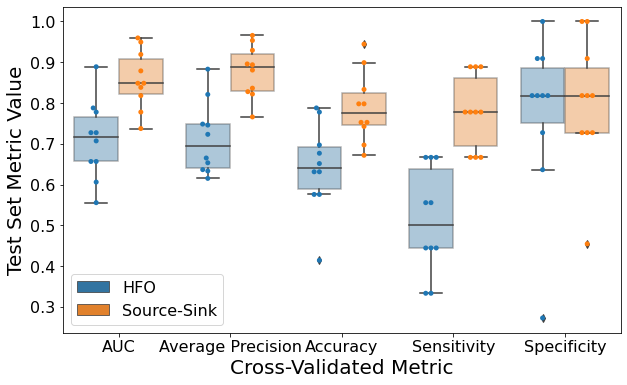

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="Metric", y="Value", hue="Feature", data=df, ax=ax, boxprops=dict(alpha=0.4)
)
sns.swarmplot(x="Metric", y="Value", hue="Feature", data=df, ax=ax, split=True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
ax.set(
    xlabel="Cross-Validated Metric",
    ylabel="Test Set Metric Value",
)
fig.savefig(figure_dir / "compare_metrics.pdf", bbox_inches="tight")